In [141]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [142]:
df = pd.read_csv('dataset_SCL.csv')

c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (1,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [ ]:
'''
Detalle de variables:

Fecha-I : Fecha y hora programada del vuelo.
Vlo-I : Número de vuelo programado.
Ori-I : Código de ciudad de origen programado.
Des-I : Código de ciudad de destino programado.
Emp-I : Código aerolínea de vuelo programado.
Fecha-O : Fecha y hora de operación del vuelo.
Vlo-O : Número de vuelo de operación del vuelo.
Ori-O : Código de ciudad de origen de operación
Des-O : Código de ciudad de destino de operación.
Emp-O : Código aerolínea de vuelo operado.
DIA : Día del mes de operación del vuelo.
MES : Número de mes de operación del vuelo.
AÑO : Año de operación del vuelo.
DIANOM : Día de la semana de operación del vuelo.
TIPOVUELO : Tipo de vuelo, I =Internacional, N =Nacional.
OPERA : Nombre de aerolínea que opera.
SIGLAORI : Nombre ciudad origen.
SIGLADES : Nombre ciudad destino.
'''

In [143]:
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


# Desafío

##### ¿Cómo se distribuyen los datos? ¿Qué te llama la atención o cuál es tu conclusión sobre esto?

El dataset cuenta con 68.206 filas y 18 columnas

In [144]:
df.shape

(68206, 18)

Tenemos solo un dato nulo en el campo 'Vlo-O' (Número de vuelo de operación del vuelo.)

In [145]:
df.isnull().sum()

Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64

In [146]:
df[df['Vlo-O'].isnull()]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19,1,2017,Jueves,I,Latin American Wings,Santiago,Lima


Podemos ver que en 97% de os casos el campo 'Vlo-O' es identico al campo 'Vlo-I', por lo tanto, para este caso nulo remplazaremos ese valor.

In [147]:
df[df['Vlo-O']==df['Vlo-I']].shape[0]/df.shape[0]

0.9728762865437058

In [148]:
df['Vlo-O'] = df['Vlo-O'].fillna(df['Vlo-I'])

Al ver los tipos de datos, vemos que predominan los datos categoricos. 

Tranformaremos los campos 'Fecha-I' y 'Fecha-O' de object a datetime

In [149]:
df.dtypes

Fecha-I      object
Vlo-I        object
Ori-I        object
Des-I        object
Emp-I        object
Fecha-O      object
Vlo-O        object
Ori-O        object
Des-O        object
Emp-O        object
DIA           int64
MES           int64
AÑO           int64
DIANOM       object
TIPOVUELO    object
OPERA        object
SIGLAORI     object
SIGLADES     object
dtype: object

In [150]:
df[["Fecha-I", "Fecha-O"]] = df[["Fecha-I", "Fecha-O"]].apply(pd.to_datetime)

El rango temporal de los vuelos porgramados corresponde a todo el año 2017, en los vuelos programados a última hora del 2017 desbordaron al al 1 de enero del 2018.

Al graficar los datos, se observan peaks en la epoca de verano, vavaciones de invierno y una disminución entre marzo y julio.

Los campos DIA, MES, AÑO, corresponden a la Fehca de operación. Crearemos campos similares para la Fecha Programada.

Más adelante observaremos en mayor detalle los cruces por tipo de vuelo, destinos, horarios, etc.

In [151]:
df.describe(datetime_is_numeric= True)

,Fecha-I,Fecha-O,DIA,MES,AÑO
count,68206,68206,68206.000000,68206.000000,68206.000000
mean,2017-07-05 12:11:25.320059648,2017-07-05 12:20:31.971380992,15.714790,6.622585,2017.000029
min,2017-01-01 00:15:00,2017-01-01 00:04:00,1.000000,1.000000,2017.000000
25%,2017-03-31 12:41:15,2017-03-31 12:51:15,8.000000,3.000000,2017.000000
50%,2017-07-10 05:30:00,2017-07-10 05:37:00,16.000000,7.000000,2017.000000
75%,2017-10-08 11:18:45,2017-10-08 11:19:45,23.000000,10.000000,2017.000000
max,2017-12-31 23:55:00,2018-01-01 00:12:00,31.000000,12.000000,2018.000000
std,NaN,NaN,8.782886,3.523321,0.005415


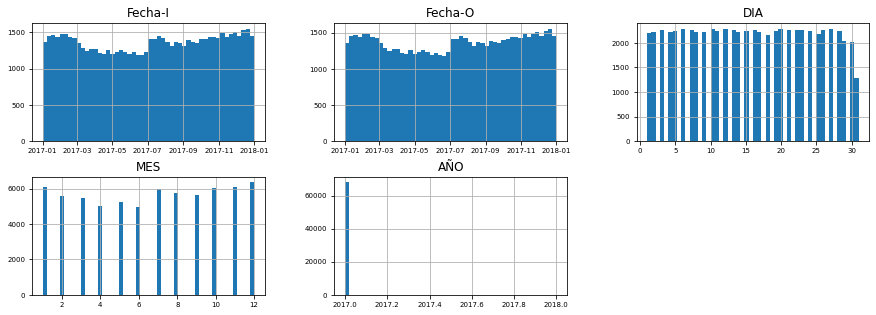

In [152]:
df.hist(figsize=(15, 5), bins=50, xlabelsize=7, ylabelsize=7, layout = (2,3));

Al analizar los datos categoricos vemos lo siguiente:

Tenemos 750 codigos de vuelos únicos en el campo 'Vlo-I' y 866 en el campo 'Vlo-O'. ¿Los vuelos con cambios de codigo implicaran algun atraso? Crearemos esa variable más adelante para validar.

Origene del vuelo: 'Ori-I', 'Ori-O', y SIGLAORI son todas únicas y hacen referencia a Santiago de forma consitente. Al momoento de modelar no consideraremso estas variable ya que no aportan información para discriminar.

Destinos del vuelo: 'Des-I' (64 únicos), 'Des-O' (63 únicos), SIGLADES (62 únicos). Al igual que con número de vuelo observaremos si hay diferencias en los destinos programados/operados y si tienen implicancia con atrasos.

Empresas: Emp-I(30 únicas), Emp-O(32 únicas) y OPERA (23 únicas). Veremos el porque de los distintos valores y si podemos quedarnos solo con 'Emp-I' al momento de entrenar el modelo.

Día del vuelo: DIANOM, contiene los 7 días de la semana, y el mayoritario es el día viernes.

Tipo de Vuelo: de los 68mil vuelos, 37mil son nacionales. 

**Aqui una nota sobre el problema: cuando estemos modelando si un vuelo tendrá atras o no, para evitar leak de información que no tendriamos a disposición en una caso real, no podemos considerar como variables predictoras las variables con '-O' ya que es información futura al momento de la programación de un vuelo.**


In [153]:
df.describe(include=['O']).transpose()


,count,unique,top,freq
Vlo-I,68206,750,174,686
Ori-I,68206,1,SCEL,68206
Des-I,68206,64,SCFA,5787
Emp-I,68206,30,LAN,37611
Vlo-O,68206,866,174,649
Ori-O,68206,1,SCEL,68206
Des-O,68206,63,SCFA,5786
Emp-O,68206,32,LAN,20988
DIANOM,68206,7,Viernes,10292
TIPOVUELO,68206,2,N,36966


A continuación exploraremos graficamente las  variables categoricas:

Destinos: Los destinos más frecuentes son Buenos Aires, Antofagasta, Lima, Calama y Puerto Montt. 

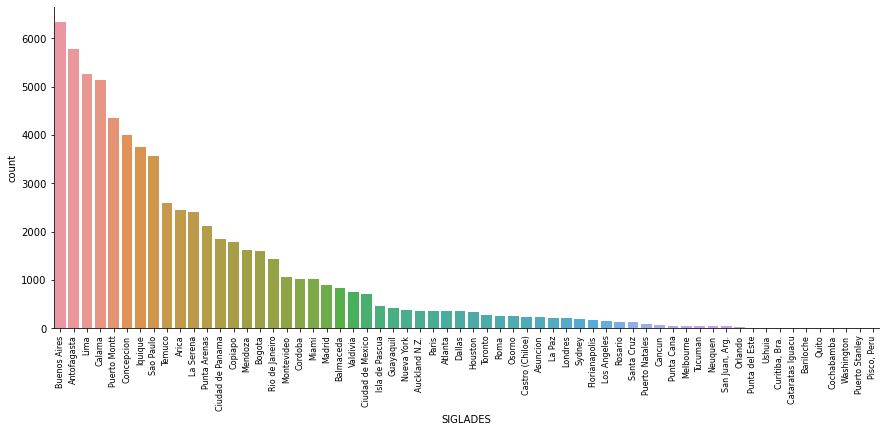

In [154]:
sns.catplot(data=df, 
            x='SIGLADES', 
            kind="count", 
            order = df['SIGLADES'].value_counts().index, 
            height=5, aspect=2.5)
plt.xticks(rotation=90, size = 8)
plt.show()

Un alternativa a explorar sería obtener la geolocalización de los destinos y calcular la distancia del vuelo.

Como hipotesis, Un vuelo de alta distancia deberia mover muchos más pasajeros y probablemente exista más probabilidad de atraso.

Una busqueda en google, nos muestra que en el siguiente sitio tenemos todos los aeropuertos con codigo y coordenadas:
https://ourairports.com/data/

In [155]:
aeropuertos = pd.read_csv('airports.csv')
#correción de aeropuerto de Perú https://ourairports.com/airports/SPIM/
aeropuertos['ident'] = np.where(aeropuertos['ident']=='SPIM', 'SPJC', aeropuertos['ident']) 

In [156]:
#Cruzamos la ubicacion de destino y origen
df = df.merge(aeropuertos[['ident','latitude_deg','longitude_deg']],
                         left_on='Des-I', right_on='ident', how='left')
df = df.merge(aeropuertos[['ident','latitude_deg','longitude_deg']],
                         left_on='Ori-I', right_on='ident', how='left')
#renombramos campos
df = df.rename(columns={'latitude_deg_x': 'latitud_des', 'longitude_deg_x': 'longitude_des',
                        'latitude_deg_y': 'latitud_ori', 'longitude_deg_y': 'longitude_ori'})
df = df.drop(['ident_x','ident_y'], axis = 1)

In [157]:
#Función para calcular distancia
#https://stackoverflow.com/questions/40452759/pandas-latitude-longitude-to-distance-between-successive-rows
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

In [158]:
df['distancia'] = haversine(df['latitud_des'],df['longitude_des'],df['latitud_ori'],df['longitude_ori']).round().astype(int)

La mayoría de los vuelos tienen una distancia de menos de 1.000km

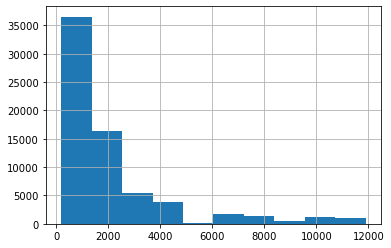

In [159]:
df.distancia.hist()
plt.show()

En vuelos nacionales tenemos 4 empresas, mientras que en Internacionales hay una alta cardinalidad.

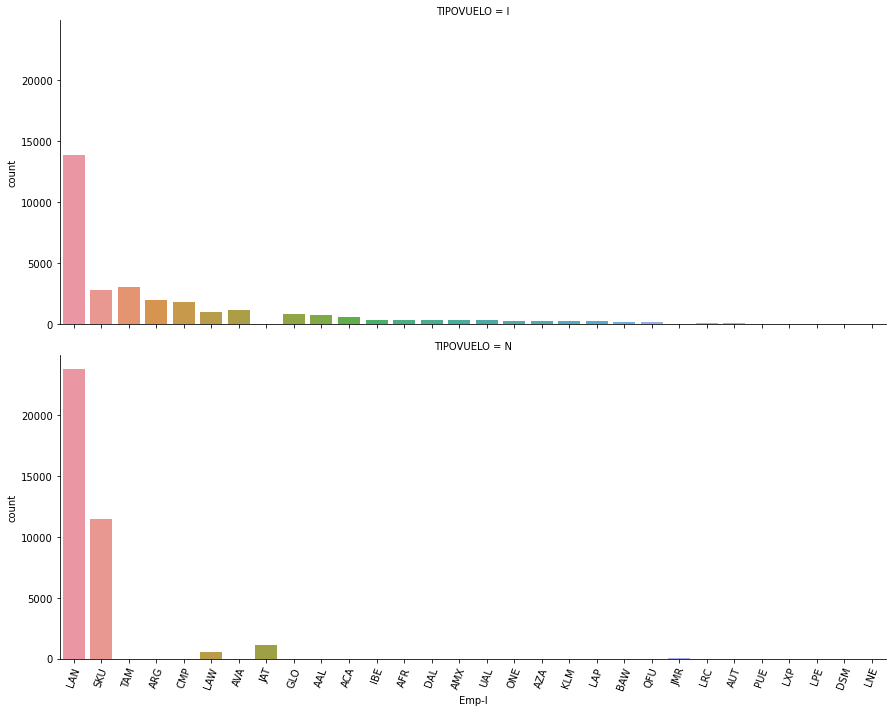

In [160]:
sns.catplot(data=df, 
            x='Emp-I', 
            kind="count", 
            row='TIPOVUELO',
            order = df['Emp-I'].value_counts().index, 
            height=5, aspect=2.5)
plt.xticks(rotation=70)
#plt.xlabel('Vlo-I',fontsize=1)
plt.tight_layout()

Viernes, Jueves y Lunes son los días con más vuelos. Sábado es el día menos cargado.

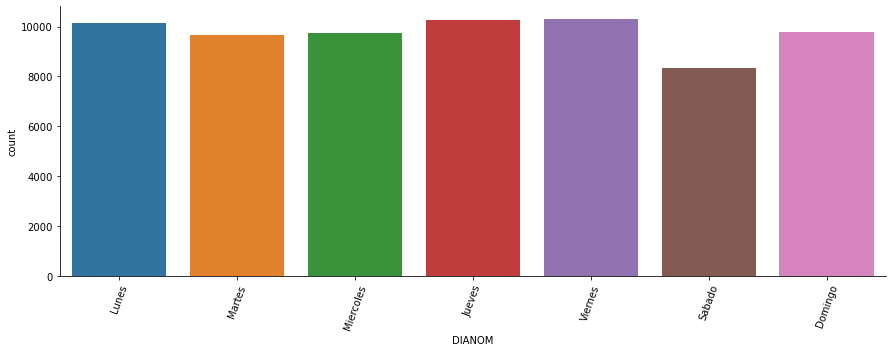

In [161]:
sns.catplot(data=df, 
            x='DIANOM', 
            kind="count",
            order = ['Lunes','Martes','Miercoles','Jueves','Viernes','Sabado','Domingo'],
            height=5, aspect=2.5)
plt.xticks(rotation=70)
#plt.xlabel('Vlo-I',fontsize=1)
plt.tight_layout()

##### Genera las columnas adicionales y luego expórtelas en un archivo 'synthetic_features.csv'

In [ ]:
''' 
temporada_alta : 1 si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no.
dif_min : diferencia en minutos entre Fecha-O y Fecha-I .
atraso_15 : 1 si dif_min > 15, 0 si no.
periodo_dia : mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a
Fecha-I .
'''

In [181]:
def temporada_alta(fecha):
    fecha = datetime.date(year=1900, month=fecha.month, day=fecha.day)

    if   datetime.date(1900, 12, 15) <= fecha <= datetime.date(1900, 3, 3) or \
         datetime.date(1900, 7, 15) <= fecha <= datetime.date(1900, 7, 31) or \
         datetime.date(1900, 9, 11) <= fecha <= datetime.date(1900, 9, 30):

        return 1
    else:
        return 0       

In [182]:
df['temporada_alta'] = df.apply(lambda x: temporada_alta(x['Fecha-I']), axis=1)

In [185]:
def diferencia_minutos(fecha_fin, fecha_ini):
    return int(round((fecha_fin - fecha_ini).total_seconds() / 60.0))

In [186]:
df['dif_min'] = df.apply(lambda x: diferencia_minutos(x['Fecha-O'],x['Fecha-I']), axis=1)

In [187]:
df['atraso_15 '] = np.where(df['dif_min'] > 15, 1, 0)

In [191]:
def periodo_dia(hora):
    hora = datetime.time(hour = hora.hour, minute = hora.minute)
    if datetime.time(5,0) <= hora <= datetime.time(11,56):
        return 'mañana'
    elif datetime.time(12,0) <= hora <= datetime.time(18,59):
        return 'tarde'
    else:
        return 'noche'

In [192]:
df['periodo_dia'] = df.apply(lambda x: periodo_dia(x['Fecha-I']), axis=1)